In [1]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import Counter
import datetime
from typing import Sequence
from tqdm import tqdm
from torch.utils.data import Subset
import matplotlib.patches as patches

torch.manual_seed(265)


Load the datasets and create subset for the most compicated model

In [67]:
detection_test = torch.load("INF265v23-Project2/detection_test.pt")
detection_train = torch.load("INF265v23-Project2/detection_train.pt")
detection_val = torch.load("INF265v23-Project2/detection_val.pt")
detection_trainn = detection_train
print(detection_train[0][0].size())

indices = np.arange(13440)  # 0 to 999

# Create the subset
detection_train_subset = Subset(detection_train, indices)
img, label = detection_train[0]

indices_val = np.arange(2944)  # 0 to 999

# Create the subset
detection_val_subset = Subset(detection_val, indices_val)

torch.Size([1, 48, 60])


Inspect the first and second image to make sure the data is normalized

In [3]:

# Check the first few items to understand their value ranges and shapes
first_image, first_label = detection_train_subset[0]
second_image, second_label = detection_train_subset[1]

# Return shapes and value ranges for both images and labels
(image_shape_1, image_min_1, image_max_1, label_shape_1, label_1), \
(image_shape_2, image_min_2, image_max_2, label_shape_2, label_2) = \
(
    (first_image.shape, first_image.min().item(), first_image.max().item(), first_label.shape, first_label),
    (second_image.shape, second_image.min().item(), second_image.max().item(), second_label.shape, second_label)
)

image_shape_1, image_min_1, image_max_1, label_shape_1, label_1, \
image_shape_2, image_min_2, image_max_2, label_shape_2, label_2

(torch.Size([1, 48, 60]),
 0.0,
 1.0,
 torch.Size([2, 3, 6]),
 tensor([[[1.0000, 0.7750, 0.8125, 0.3500, 0.7917, 1.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.9500, 0.3333, 0.7000, 0.6667, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]),
 torch.Size([1, 48, 60]),
 0.0,
 1.0,
 torch.Size([2, 3, 6]),
 tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.5000, 0.3542, 0.5000, 0.9583, 1.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]))

Our different convolutional networks to solve the task.

The first one is almost completly the same as yoloV1 while the other are simpler versions

-When it is a tuple it is a conv layer.
-"M" is a maxpool layer.
-lists are repeated layers where the last digit is how many times they are repeated.

In [41]:


cnn_dict = {
    "cnn_config": [
    (7,64,2,3),
    "M",
    (3,192,1,1),
    "M",
    (1,128,1,0),
    (3,256,1,1),
    (1,256,1,0),
    (1,512,1,1),
    "M",
    [(1,512,1,0), (3,512,1,1), 4],
    (1,512,1,0),
    (3,1024,1,1),
    "M",
    [(1,512,1,0), (3,1024,1,1),2],
    (3,1024,1,1),
    (3,1024,2,1),
    (3,1024,1,1),
    (3,1024,1,1),

],
    "simple_cnn_config": [
        (7, 32, 1, 3),  
        "M",  
        (3, 64, 1, 1),
        "M", 
        (3, 128, 1, 1),  
        (3, 128, 2, 1),  
        (3, 256, 1, 1),  
        (3, 256, 2, 1),  
        (1, 7, 1, 0)  
    ],

    "corrected_cnn_config_1": [
        (7, 32, 2, 3), "M",
        (3, 64, 1, 1),
        (3, 128, 1, 1), "M",
        (3, 256, 2, 1),  
        [(1, 256, 1, 0), (3, 256, 1, 1), 2], 
        (3, 512, 1, 1),
        (3, 1024, 1, 1),
        (1, 7, 1, 0) 
    ],

    "alt_cnn_config_3": [
        (7, 64, 2, 3), "M",
        (3, 128, 1, 1),
        (1, 256, 1, 0),
        (3, 512, 2, 1), 
        "M",
        (3, 1024, 1, 1),
        (1, 7, 1, 0)  
    ]
}

Class to esemble layer

In [80]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))
    

Yolo Class
inturprets the cnn configs above and creates the model architecture

In [85]:
class yolo(nn.Module):
    def __init__(self, in_channels=1, cnn__config=cnn_dict["cnn_config"], **kwargs):
        super(yolo, self).__init__()
        self.architecture = cnn__config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)


    def forward(self, x):
        x = self.darknet(x)
        if self.architecture == cnn_dict["cnn_config"]:
            x = torch.flatten(x, start_dim=1)
            x = self.fcs(x)
            N = x.size(0) 
            output = x.view(N, 2, 3, 2 + 1 * 5)
                
        else:
            features = x.permute(0, 2, 3, 1)  
            features = torch.nn.functional.adaptive_avg_pool2d(features, (2, 3))
            final_conv = torch.nn.Conv2d(3, 7, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
            output = final_conv(features).permute(0,2,3,1)

        return output
    
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                    
                ]
               
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)
    
    def _create_fcs(self, s_h, s_w, num_boxes, num_classes):
        output_size = s_h * s_w * (num_classes + num_boxes * 5)  
        intermediate_size = 1024  

        # Define the fully connected layers
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(intermediate_size, 496),  
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, output_size), 

        )
    


Code to save and load models

In [88]:

def save_checkpoint(state, filename):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

#save a given model with name
def save_current_model(model, optimizer, name):
    checkpoint = {
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, filename=(name +'.pth.tar'))
    import time
    time.sleep(2)


Loss function

In [8]:

def yolo_loss(preds, targets):
    
    pred_obj_score = preds[..., 0:1] 
    target_obj_score = targets[..., 0:1]
    
    pred_boxes = preds[..., 1:5]
    target_boxes = targets[..., 1:5]
    
    pred_classes = preds[..., 5:]  
    
    target_classes = targets[..., -1].long()
    
    # Compute objectness loss (binary classification: object vs. no object)
    obj_loss = F.binary_cross_entropy_with_logits(pred_obj_score, target_obj_score, reduction='mean')
    
    # Compute localization loss (mean squared error for bounding boxes)
    box_loss = F.mse_loss(pred_boxes, target_boxes, reduction='mean')
    
    # Compute classification loss
    N, Hout, Wout, _ = preds.shape
    pred_classes_flat = pred_classes.reshape(N * Hout * Wout, -1)
    target_classes_flat = target_classes.view(-1)
    class_loss = F.cross_entropy(pred_classes_flat, target_classes_flat, reduction='mean')
    
    
    total_loss = obj_loss + box_loss + class_loss

    return total_loss


Train function

In [9]:
#Load the dataset
train_loader = torch.utils.data.DataLoader(detection_train_subset, batch_size=64, shuffle=False)
validation_loader = torch.utils.data.DataLoader(detection_val, batch_size=64, shuffle=False)

#Trains the model
def train_fn(train_loader, model, optimizer, loss_fn):
    model.train()
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for img, label in loop:
        out = model(img)
        loss = loss_fn(out, label)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    return sum(mean_loss) / len(mean_loss)


# Calculates average loss for each epoch 
def validate(validation_loader, model, loss_fn):
    model.eval()
    mean_loss = []
    with torch.no_grad():
        for img, label in validation_loader:
            out = model(img)
            loss = loss_fn(out, label)
            mean_loss.append(loss.item())

    return sum(mean_loss) / len(mean_loss)

Main training loop

In [51]:
LEARNING_RATE = 1e-2
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 0
EPOCHS = 50

config_list = ['simple_cnn_config', 'corrected_cnn_config_1', 'alt_cnn_config_3', 'cnn_config']

def main(train_loader, validation_loader, model, optimizer, loss_fn, epochs, name, patience=3):

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss = train_fn(train_loader, model, optimizer, loss_fn)
        val_loss = validate(validation_loader, model, loss_fn)
        
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        
        # Check if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # reset patience counter
            print("Validation loss decreased, saving model...")
            # You can save your model here if you wish
            save_current_model(model, optimizer, name)
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"Early stopping triggered. stopped at {epoch}")
                break
    save_current_model(model, optimizer, name)

for cnn in config_list:
    model = model = yolo(cnn__config=cnn_dict[cnn], s_h=2, s_w=3, num_boxes=1, num_classes=2)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_func = yolo_loss
    main(train_loader, validation_loader, model, optimizer, loss_func, EPOCHS,cnn)


    

42
Epoch 1/50


  0%|          | 0/210 [00:00<?, ?it/s]

100%|██████████| 210/210 [01:13<00:00,  2.85it/s, loss=1.5] 


Training Loss: 1.6591
Validation Loss: 1.6866
Validation loss decreased, saving model...
=> Saving checkpoint
Epoch 2/50


100%|██████████| 210/210 [00:59<00:00,  3.56it/s, loss=1.8] 


Training Loss: 1.6355
Validation Loss: 1.6999
Validation loss did not improve. Patience: 1/3
Epoch 3/50


100%|██████████| 210/210 [00:55<00:00,  3.77it/s, loss=1.69]


Training Loss: 1.6424
Validation Loss: 1.5669
Validation loss decreased, saving model...
=> Saving checkpoint
Epoch 4/50


100%|██████████| 210/210 [00:54<00:00,  3.83it/s, loss=1.28]


Training Loss: 1.6182
Validation Loss: 1.6266
Validation loss did not improve. Patience: 1/3
Epoch 5/50


100%|██████████| 210/210 [00:57<00:00,  3.68it/s, loss=1.56]


Training Loss: 1.6193
Validation Loss: 1.6827
Validation loss did not improve. Patience: 2/3
Epoch 6/50


100%|██████████| 210/210 [00:58<00:00,  3.57it/s, loss=1.44]


Training Loss: 1.6434
Validation Loss: 1.6256
Validation loss did not improve. Patience: 3/3
Early stopping triggered. stopped at 5
=> Saving checkpoint
42
Epoch 1/50


100%|██████████| 210/210 [01:34<00:00,  2.21it/s, loss=1.57]


Training Loss: 1.6475
Validation Loss: 1.6563
Validation loss decreased, saving model...
=> Saving checkpoint
Epoch 2/50


100%|██████████| 210/210 [01:46<00:00,  1.97it/s, loss=1.53]


Training Loss: 1.6414
Validation Loss: 1.6131
Validation loss decreased, saving model...
=> Saving checkpoint
Epoch 3/50


100%|██████████| 210/210 [01:29<00:00,  2.35it/s, loss=1.62]


Training Loss: 1.6547
Validation Loss: 1.6341
Validation loss did not improve. Patience: 1/3
Epoch 4/50


100%|██████████| 210/210 [01:28<00:00,  2.36it/s, loss=1.94]


Training Loss: 1.6297
Validation Loss: 1.6533
Validation loss did not improve. Patience: 2/3
Epoch 5/50


100%|██████████| 210/210 [01:35<00:00,  2.20it/s, loss=1.81]


Training Loss: 1.6243
Validation Loss: 1.6099
Validation loss decreased, saving model...
=> Saving checkpoint
Epoch 6/50


100%|██████████| 210/210 [01:58<00:00,  1.78it/s, loss=1.6] 


Training Loss: 1.6175
Validation Loss: 1.6197
Validation loss did not improve. Patience: 1/3
Epoch 7/50


100%|██████████| 210/210 [01:58<00:00,  1.77it/s, loss=1.77]


Training Loss: 1.6221
Validation Loss: 1.6309
Validation loss did not improve. Patience: 2/3
Epoch 8/50


100%|██████████| 210/210 [01:52<00:00,  1.87it/s, loss=2.02]


Training Loss: 1.6279
Validation Loss: 1.6304
Validation loss did not improve. Patience: 3/3
Early stopping triggered. stopped at 7
=> Saving checkpoint
42
Epoch 1/50


100%|██████████| 210/210 [02:02<00:00,  1.72it/s, loss=1.65]


Training Loss: 1.6417
Validation Loss: 1.6079
Validation loss decreased, saving model...
=> Saving checkpoint
Epoch 2/50


100%|██████████| 210/210 [01:43<00:00,  2.03it/s, loss=1.77]


Training Loss: 1.6424
Validation Loss: 1.6477
Validation loss did not improve. Patience: 1/3
Epoch 3/50


100%|██████████| 210/210 [01:46<00:00,  1.97it/s, loss=1.41]


Training Loss: 1.6340
Validation Loss: 1.6332
Validation loss did not improve. Patience: 2/3
Epoch 4/50


100%|██████████| 210/210 [01:53<00:00,  1.85it/s, loss=1.38]


Training Loss: 1.5975
Validation Loss: 1.5972
Validation loss decreased, saving model...
=> Saving checkpoint
Epoch 5/50


100%|██████████| 210/210 [02:05<00:00,  1.67it/s, loss=1.92]


Training Loss: 1.6084
Validation Loss: 1.5984
Validation loss did not improve. Patience: 1/3
Epoch 6/50


100%|██████████| 210/210 [02:09<00:00,  1.62it/s, loss=1.23]


Training Loss: 1.6345
Validation Loss: 1.5884
Validation loss decreased, saving model...
=> Saving checkpoint
Epoch 7/50


100%|██████████| 210/210 [02:00<00:00,  1.74it/s, loss=1.69]


Training Loss: 1.6276
Validation Loss: 1.6584
Validation loss did not improve. Patience: 1/3
Epoch 8/50


100%|██████████| 210/210 [02:04<00:00,  1.69it/s, loss=1.28]


Training Loss: 1.6158
Validation Loss: 1.6008
Validation loss did not improve. Patience: 2/3
Epoch 9/50


100%|██████████| 210/210 [02:01<00:00,  1.72it/s, loss=1.57]


Training Loss: 1.6088
Validation Loss: 1.6412
Validation loss did not improve. Patience: 3/3
Early stopping triggered. stopped at 8
=> Saving checkpoint


In [11]:
def calculate_iou(predicted_box, target_box):
    
	x1, y1, w1, h1 = predicted_box[...,0:1], predicted_box[...,1:2], predicted_box[...,2:3], predicted_box[...,3:4]
	x2, y2, w2, h2 = target_box[...,0:1], target_box[...,1:2], target_box[...,2:3], target_box[...,3:4]

	xmin1, ymin1 = x1 - w1 / 2, y1 - h1/2
	xmax1, ymax1 = x1 + w1 / 2, y1 + h1/2
	xmin2, ymin2 = x2 - w2 / 2, y2 - h2/2
	xmax2, ymax2 = x2 + w2 / 2, y2 + h2/2

	# determine the (x, y)-coordinates of the intersection rectangle
	xmin_inter = torch.max(xmin1, xmin2)
	ymin_inter = torch.max(ymin1, ymin2)
	xmax_inter = torch.min(xmax1, xmax2)
	ymax_inter = torch.min(ymax1, ymax2)

	# compute the area of intersection rectangle
	intersection_area = torch.clamp(xmax_inter - xmin_inter, min=0) * torch.clamp(ymax_inter - ymin_inter, min=0)

	# compute the area of both the prediction and ground-truth
	# rectangles
	union_area = w1 * h1 + w2 * h2 - intersection_area + 1e-6
	
	iou = intersection_area / union_area 
	
	
	return iou


In [89]:

def convert(predictions, S_h=2, S_w=3, num_bboxes=1):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S_h, S_w, -1)
    best_boxes = predictions[..., 1:5]

    # Adjustments for x, y
    x_cell_indices = torch.arange(S_w).repeat(batch_size, S_h, 1).unsqueeze(-1).to(predictions.device)
    y_cell_indices = torch.arange(S_h).repeat(batch_size, S_w, 1).unsqueeze(-1).to(predictions.device).permute(0, 2, 1, 3)

    x = 1 / S_w * (best_boxes[..., :1] + x_cell_indices)
    y = 1 / S_h * (best_boxes[..., 1:2] + y_cell_indices)
    h_w = 1 /S_w * best_boxes[...,2:3]
    w_h = 1 / S_h * best_boxes[..., 3:4]
    converted_bboxes = torch.cat((x, y, h_w, w_h), dim=-1)

    predicted_class = predictions[..., 5:7].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 0], predictions[..., 5]).unsqueeze(-1) if num_bboxes == 2 else predictions[..., 0:1]
    converted_preds = torch.cat((predicted_class, best_confidence, converted_bboxes), dim=-1)
    return converted_preds


In [53]:

def cell_to_img(out, num_box = 1):
    converted_pred = convert(out, num_bboxes=num_box).reshape(out.shape[0], 2 * 3, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(2 * 3):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)
   
    return all_bboxes


In [28]:
def non_max_suppression(bboxes, iou_threshold, threshold):
    
    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or calculate_iou(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms



In [71]:
def performance(outputs, labels, correct_class_classification, total_class):
    total = 0
    correct_classification = 0
    predicted_class = torch.sigmoid(outputs[:,0])
    # Accuracy for object classificatio
    total += labels.shape[0]
    correct_classification += torch.sum((predicted_class > 0.5) == labels[:,0].bool())
        
    total_class += labels.shape[0]
    predicted_object = torch.argmax(outputs[:, 5:-1], dim=1)
    correct_class_classification += torch.sum(predicted_object == labels[:, 5])
    
    return correct_classification, total

In [63]:
def plot_image(image, boxes):
    im = np.array(image)
    height, width, _ = im.shape
    fig, ax = plt.subplots(1)
    ax.imshow(im)

    for box in boxes:
        box= box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle((upper_left_x * width, upper_left_y * height),box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()
    

=> Loading checkpoint
predicted classes  [0.0, 0.0]


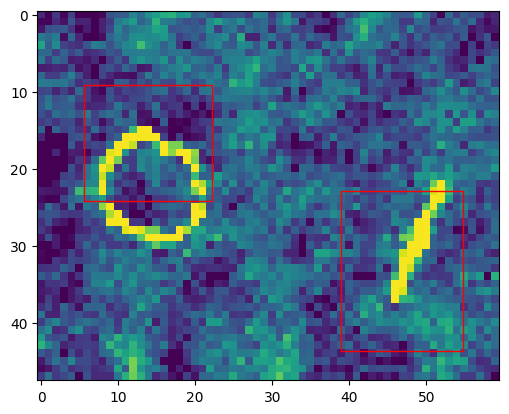

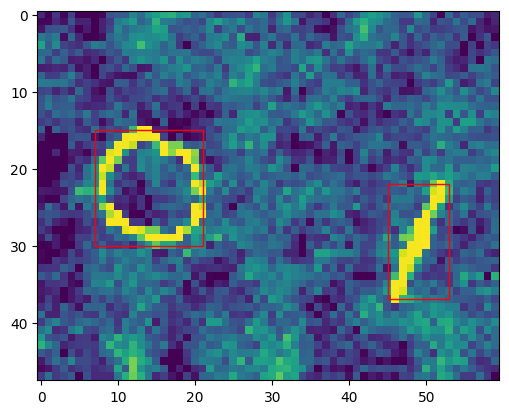

predicted classes  [0.0, 0.0]


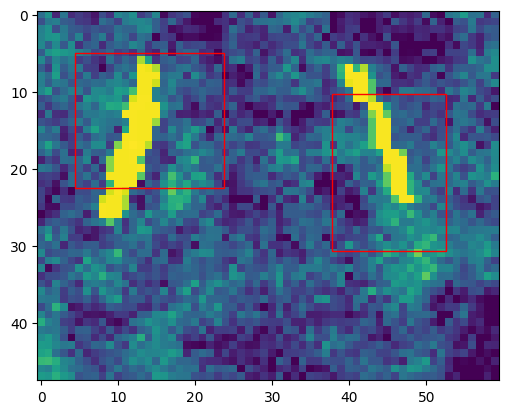

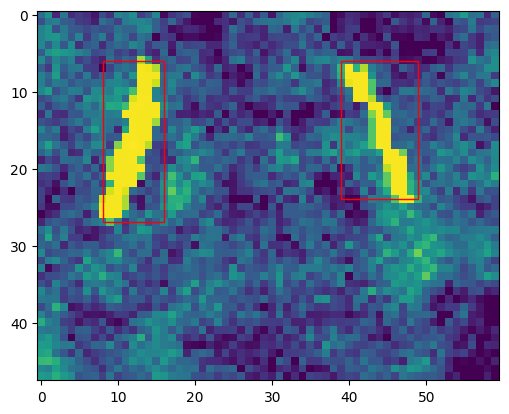

predicted classes  [1.0, 1.0]


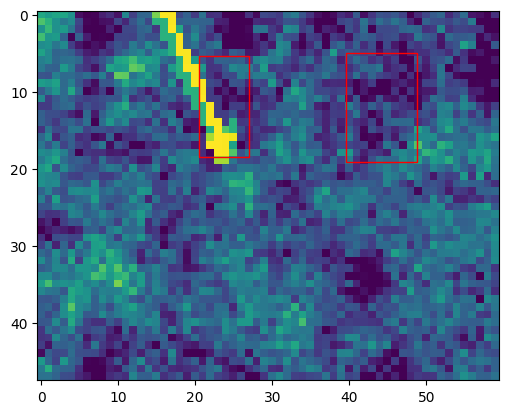

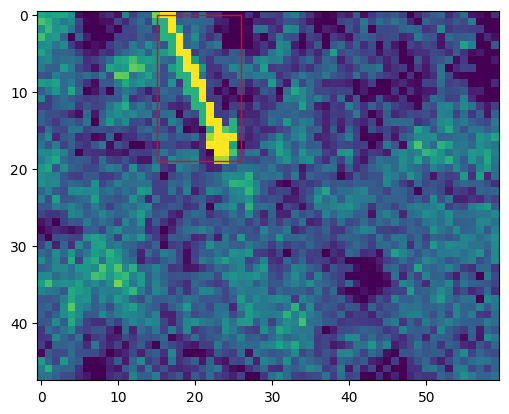

predicted classes  [0.0]


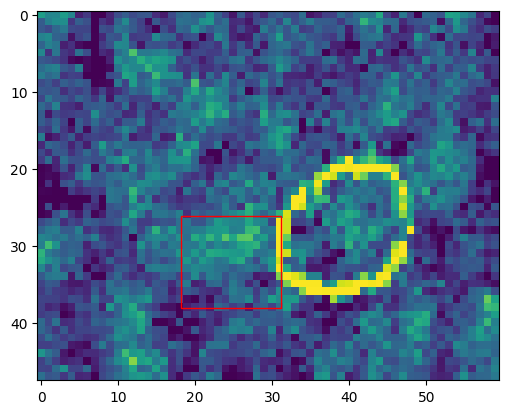

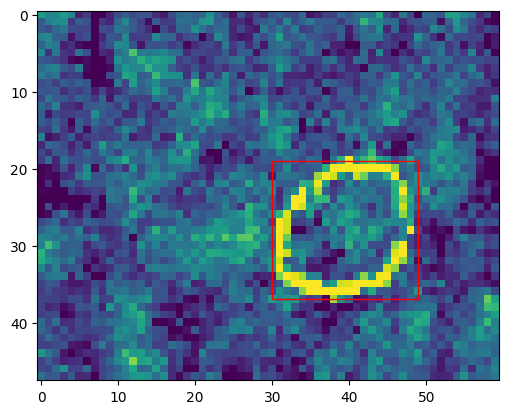

=> Loading checkpoint
predicted classes  []


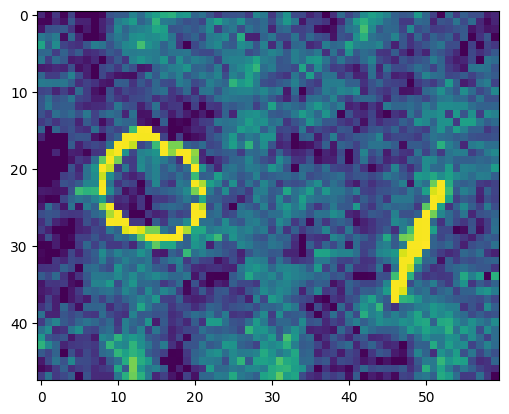

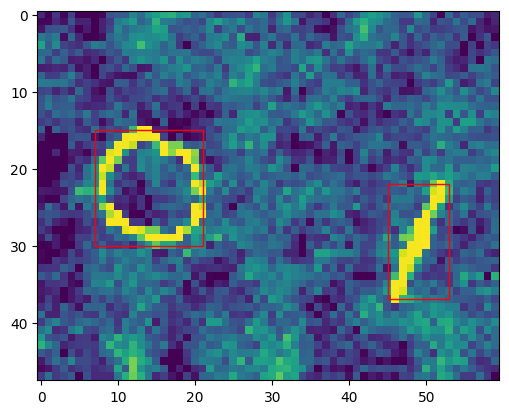

predicted classes  []


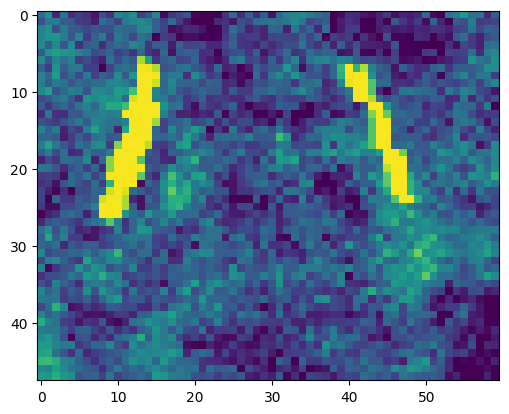

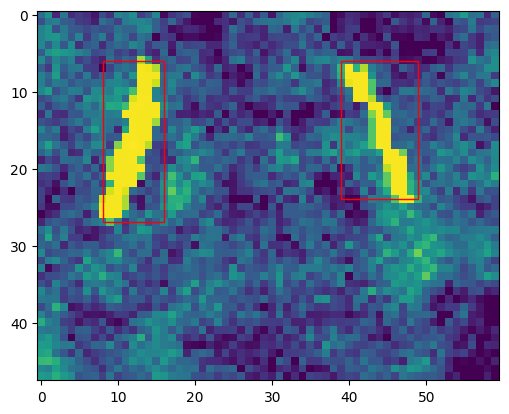

predicted classes  []


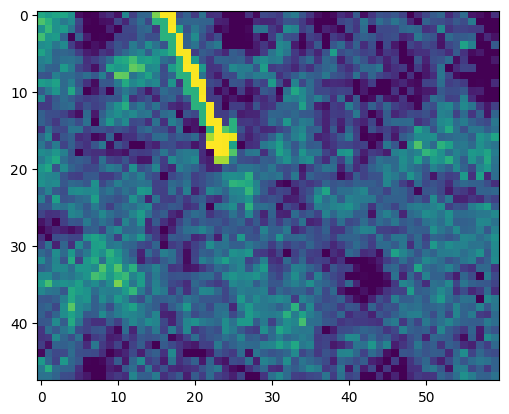

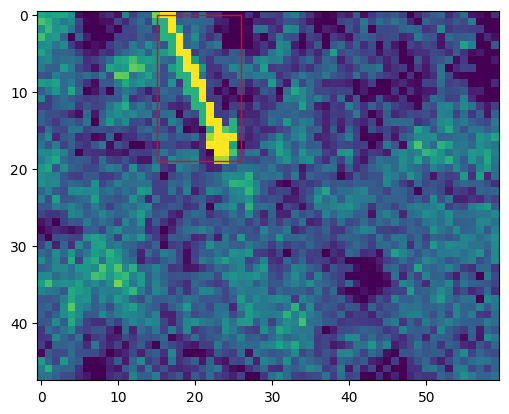

predicted classes  []


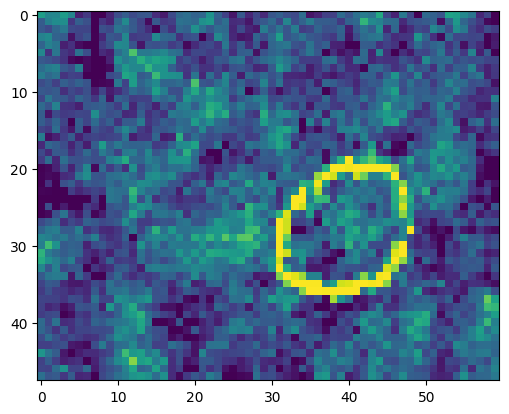

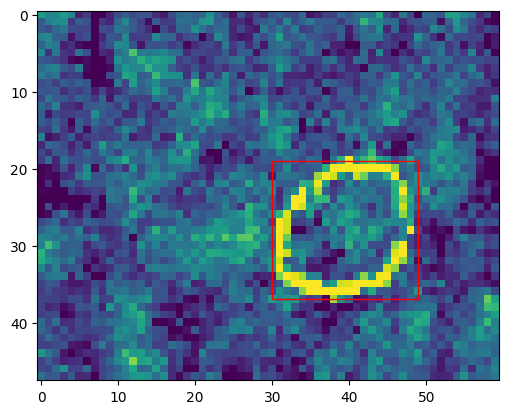

=> Loading checkpoint
predicted classes  []


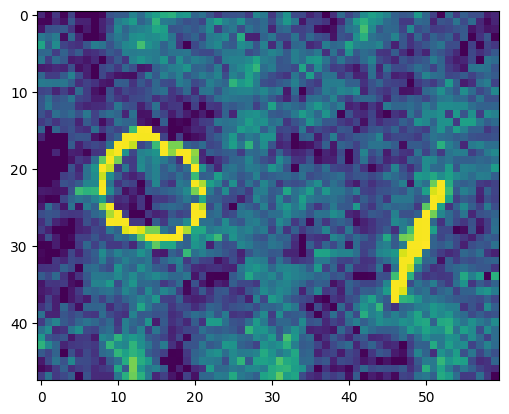

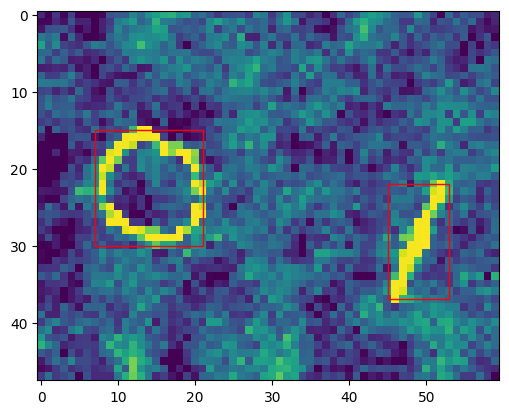

predicted classes  []


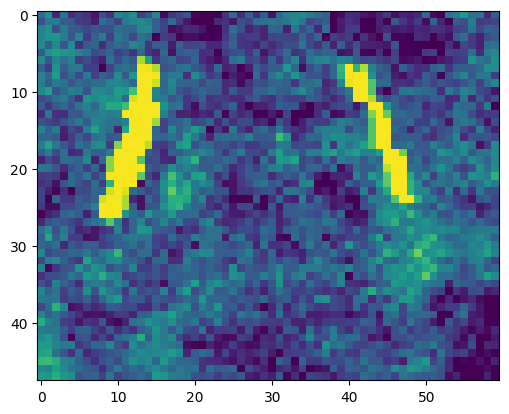

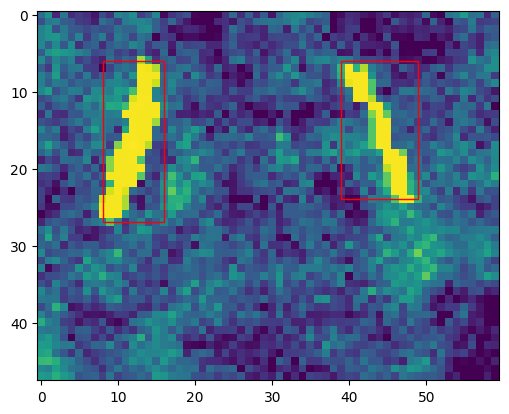

predicted classes  []


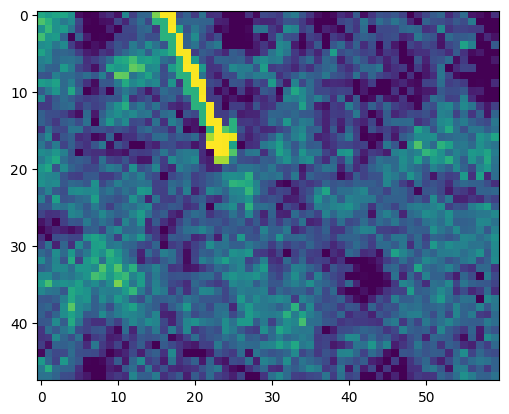

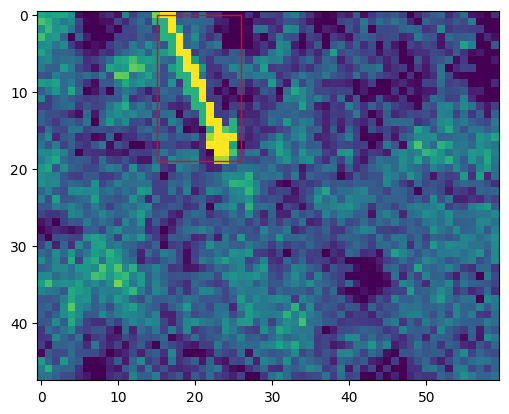

predicted classes  []


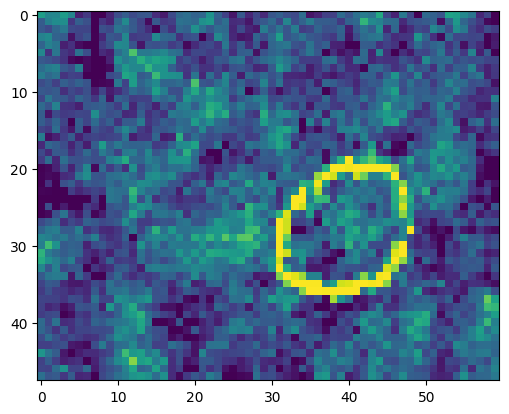

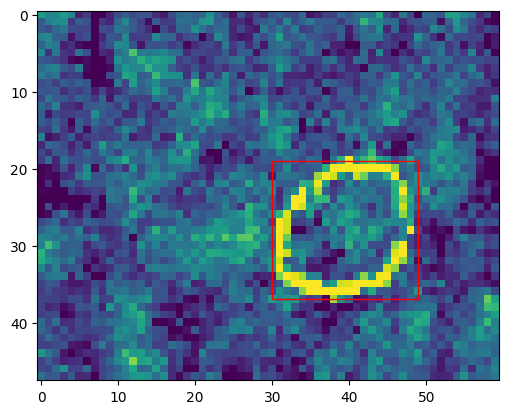

=> Loading checkpoint
predicted classes  []


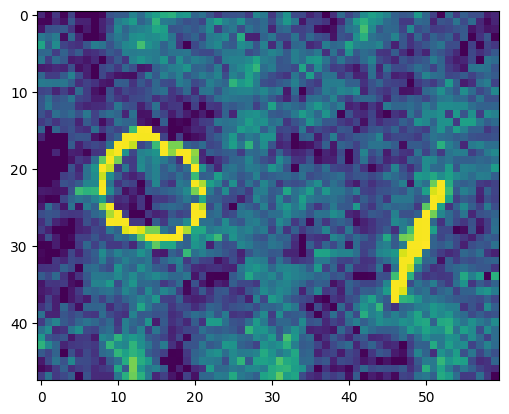

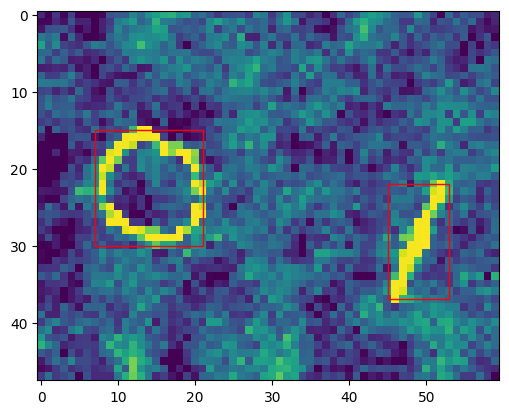

predicted classes  []


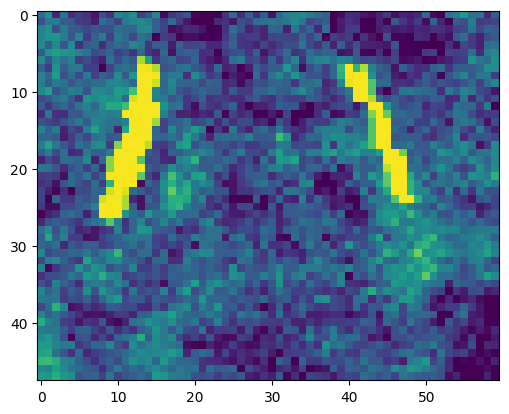

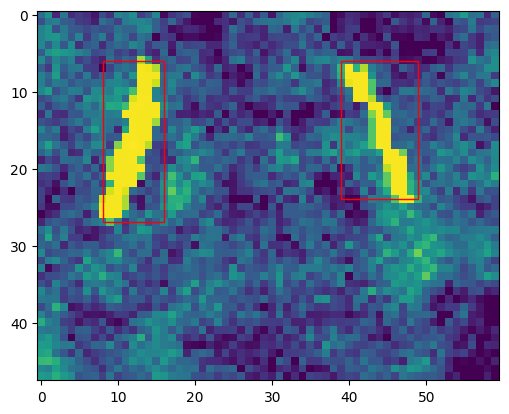

predicted classes  []


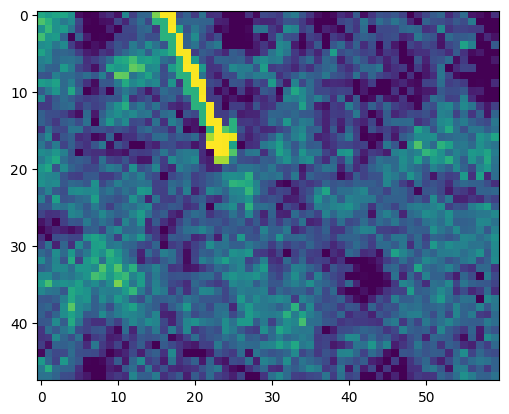

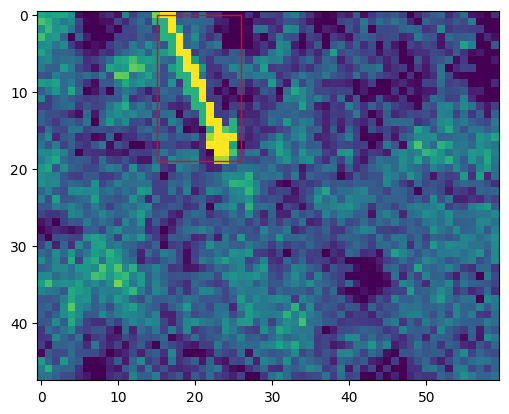

predicted classes  []


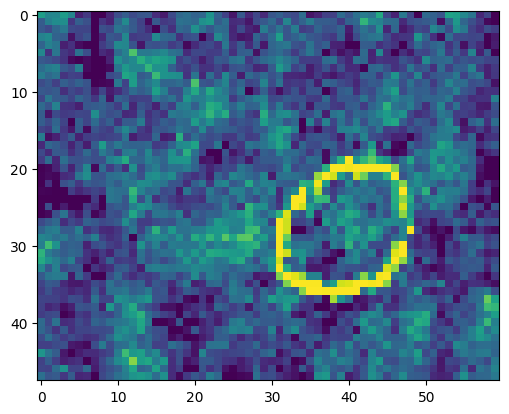

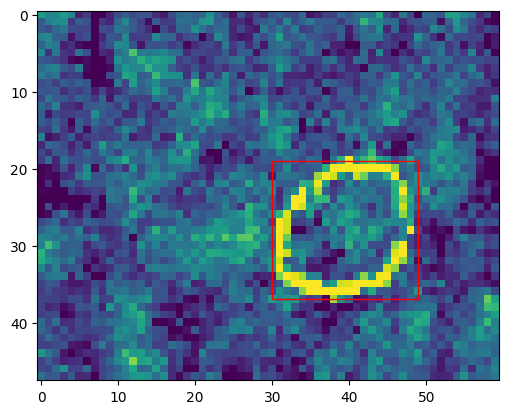

In [92]:
val_loader = torch.utils.data.DataLoader(detection_val_subset, batch_size=64, shuffle=False)
train_loader = torch.utils.data.DataLoader(detection_train_subset, batch_size=64, shuffle=False) 
test_loader = torch.utils.data.DataLoader(detection_test, batch_size=64, shuffle=False) 
BATCH_SIZE = 64
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 0
LOAD_MODELS = ['cnn_configsmalltestearlystop.pth.tar.tar', 'simple_cnn_configsmalltestearlystop.pth.tar','corrected_cnn_config_1smalltestearlystop.pth.tar','alt_cnn_config_3smalltestearlystop.pth.tar','smalltestearlystop.pth.tar']
LOAD_MODEL = False
config_list = ['cnn_config','simple_cnn_config', 'corrected_cnn_config_1', 'alt_cnn_config_3']
threshold=0.5

performance_list = []


def model_selection():
    for i, achitecture in enumerate (config_list):
        #correct_classification = 0
        #total_class = 0
        number_prints = 4
        pic = 0
        model = yolo(cnn__config=cnn_dict[achitecture], s_h=2,s_w=3, num_boxes=1, num_classes=2)
        model.eval()
        optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
        load_checkpoint(torch.load(LOAD_MODELS[i]), model, optimizer)
        for img, label in val_loader:
            output = model(img)
            #output[..., 5:5+2] = torch.softmax(output[..., 5:5+2], dim=-1)
            cell_to_box = cell_to_img(output)
            converted_labels = cell_to_img(label)
            #cc, tc = performance(output, label, correct_classification, total_class)
            #correct_classification += cc
            #total_class += tc
            for idx in range(BATCH_SIZE):
                predicted = []
                non_max = non_max_suppression(cell_to_box[idx],iou_threshold=0.5,threshold=0.5)
                converted_lab = non_max_suppression(converted_labels[idx],iou_threshold=0.5,threshold=0.5)
                if number_prints > pic:
                    for pre in non_max:
                            predicted.append(pre[0])
                    print('predicted classes ', predicted)
                    plot_image(img[idx].permute(1,2,0).to("cpu"), non_max)
                    plot_image(img[idx].permute(1,2,0).to("cpu"), converted_lab)
                    pic += 1
        #performance_list.append(correct_classification/total_class)
    #print(performance_list)
model_selection()


#here we are supposed to predict with the best model on test data. But since we dont have a performance
#meassure there is no reason for this. The code would be identical to the one above but with test_loader
#instead of val_loader.
      

=> Loading checkpoint
predicted classes  [1.0, 0.0]


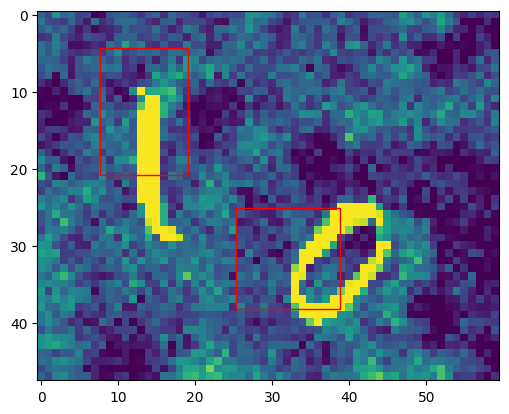

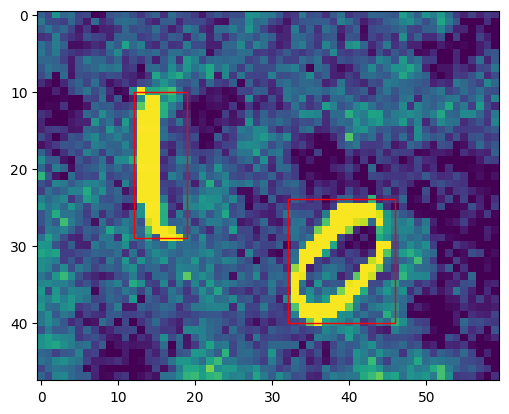

predicted classes  [0.0, 0.0]


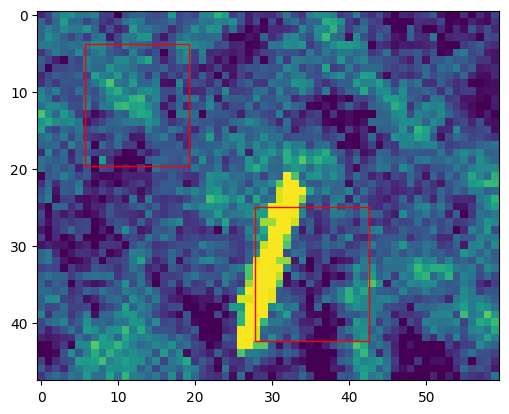

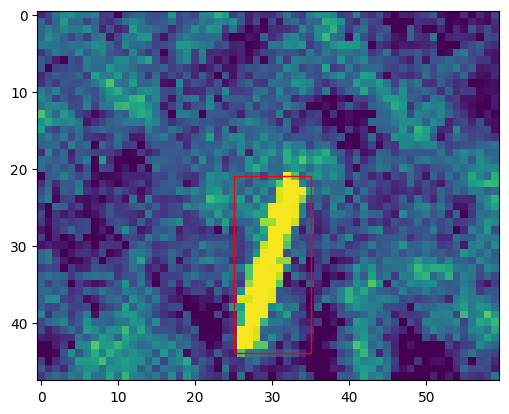

predicted classes  [0.0]


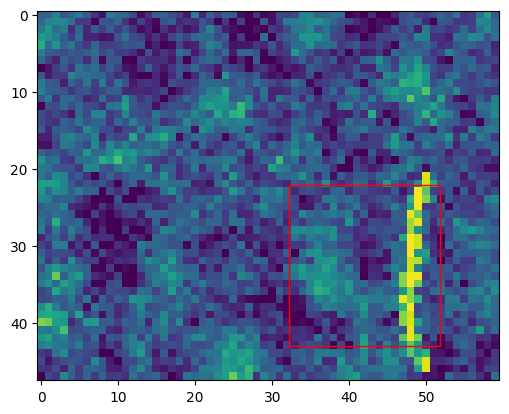

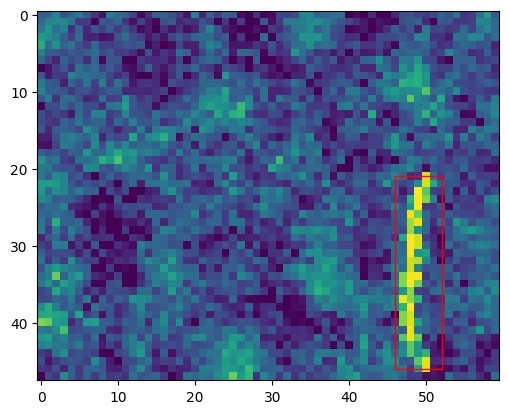

predicted classes  [0.0, 0.0]


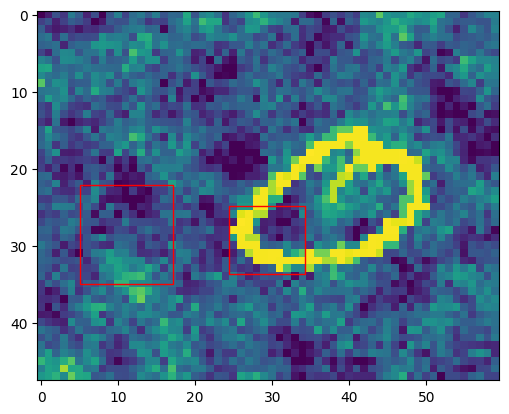

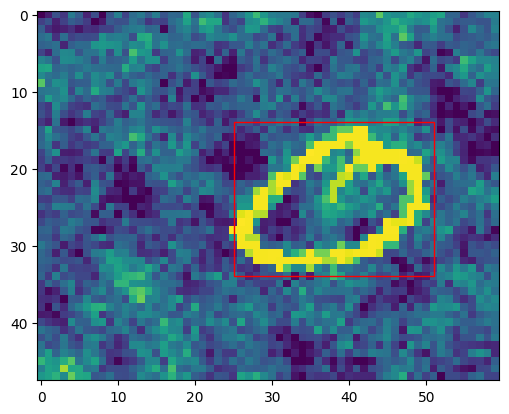

=> Loading checkpoint
predicted classes  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


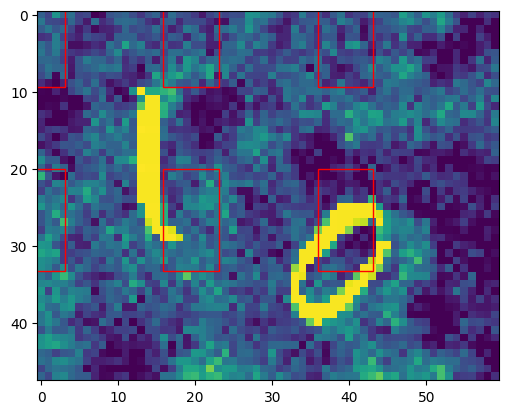

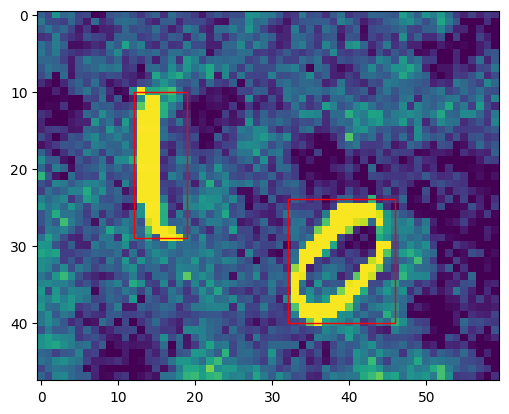

predicted classes  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


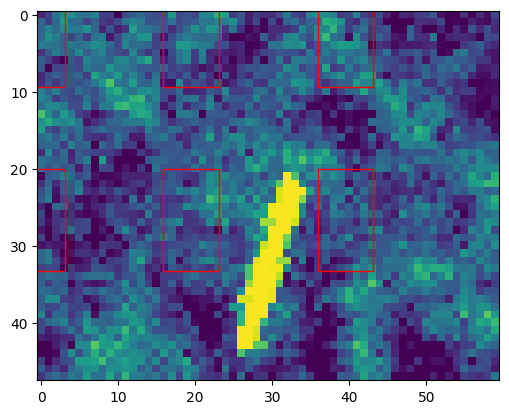

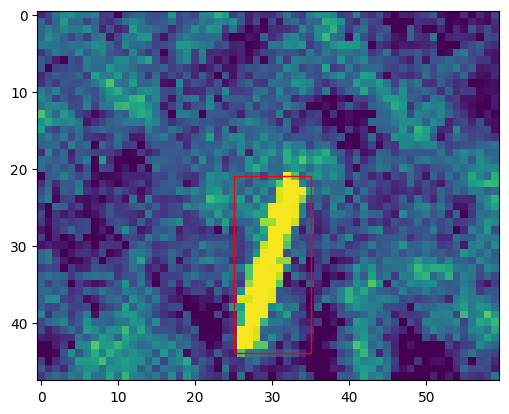

predicted classes  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


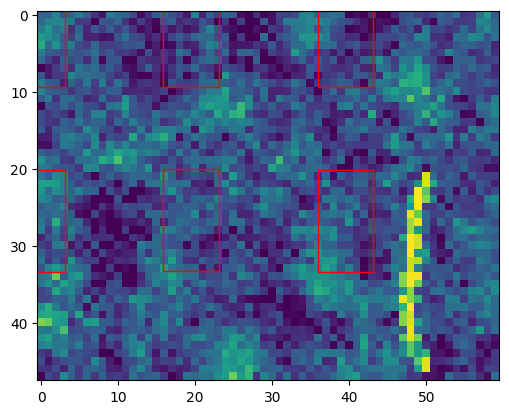

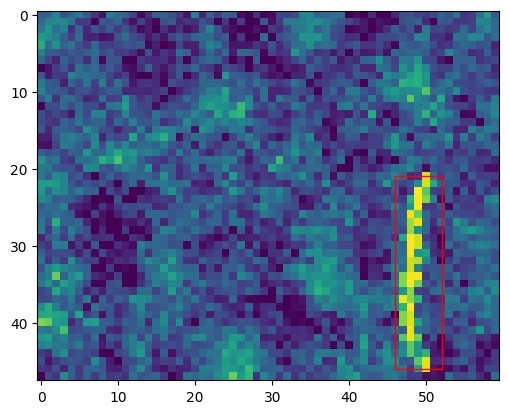

predicted classes  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


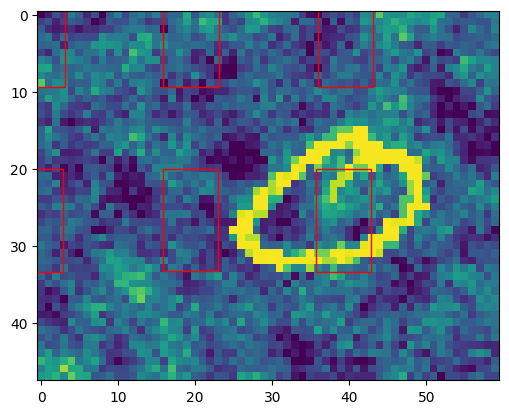

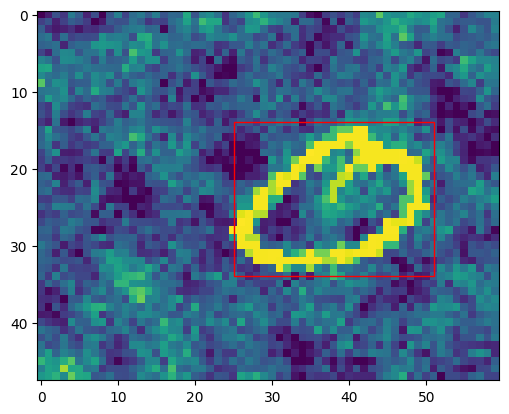

=> Loading checkpoint
predicted classes  []


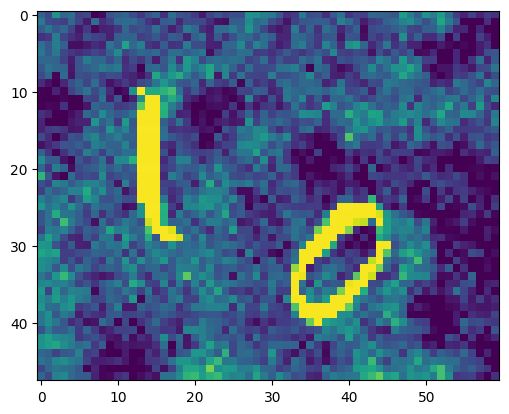

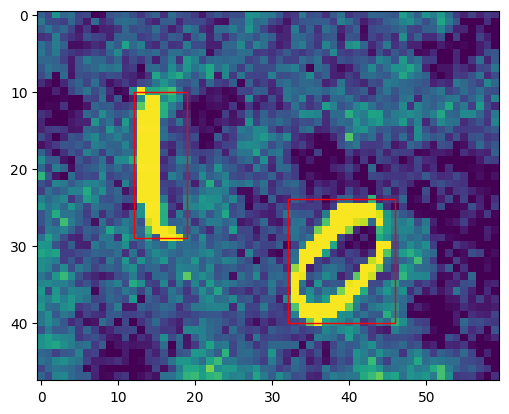

predicted classes  []


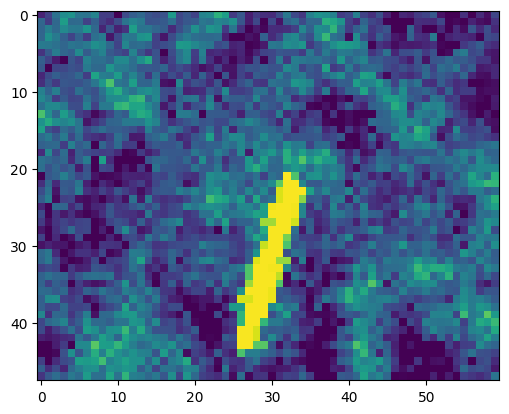

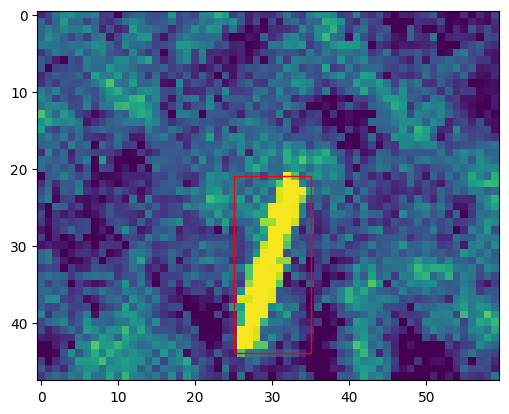

predicted classes  []


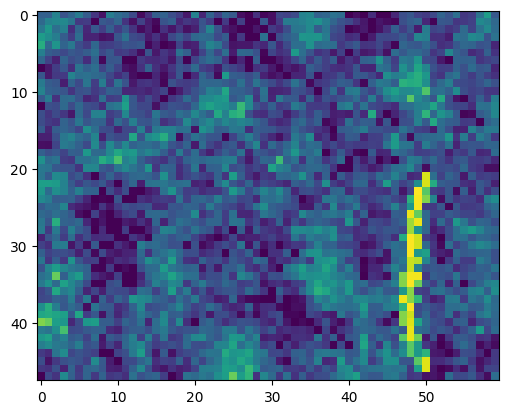

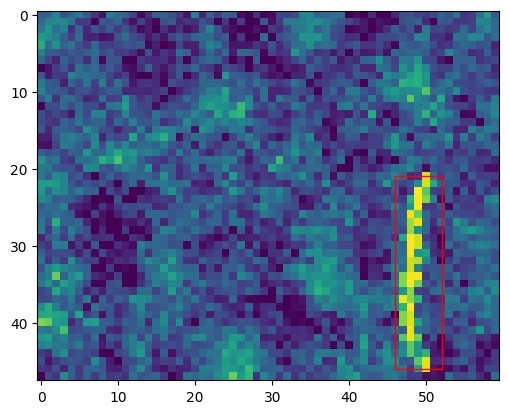

predicted classes  []


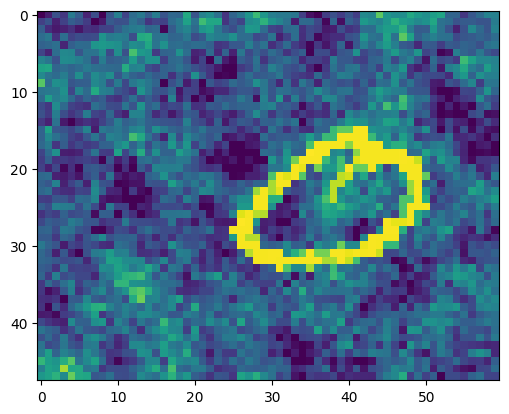

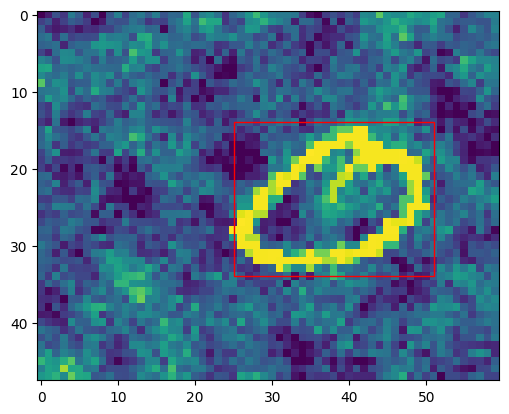

=> Loading checkpoint
predicted classes  []


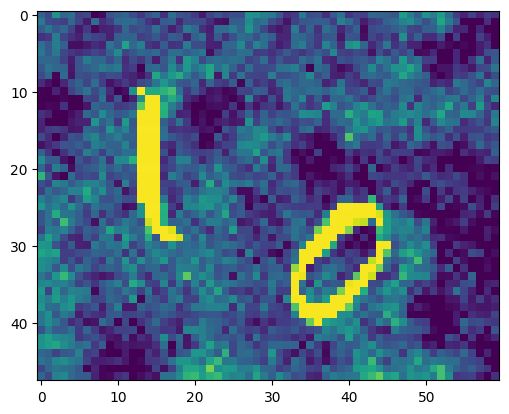

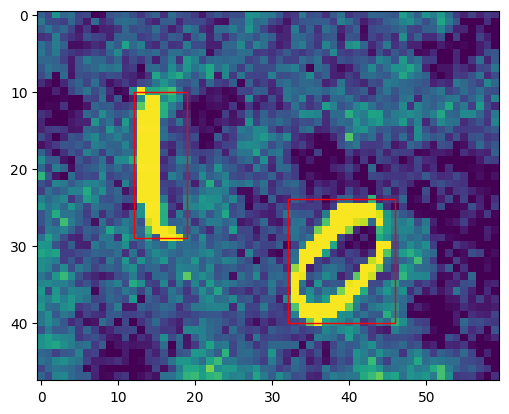

predicted classes  []


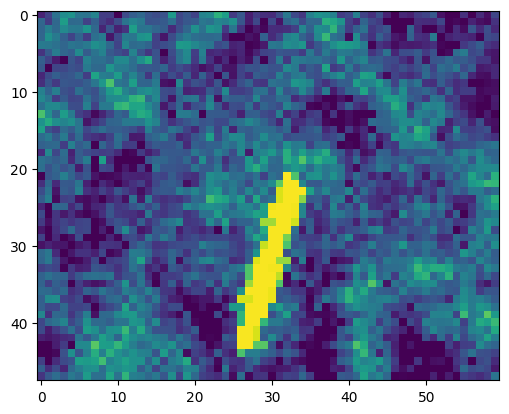

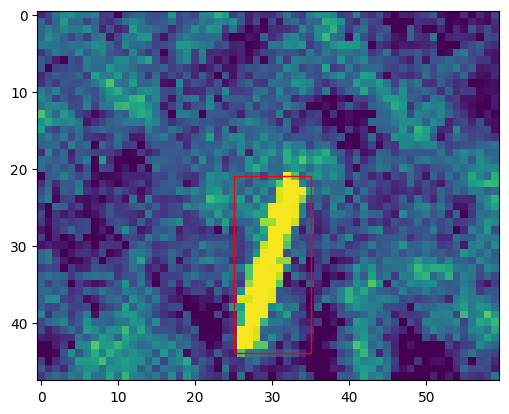

predicted classes  []


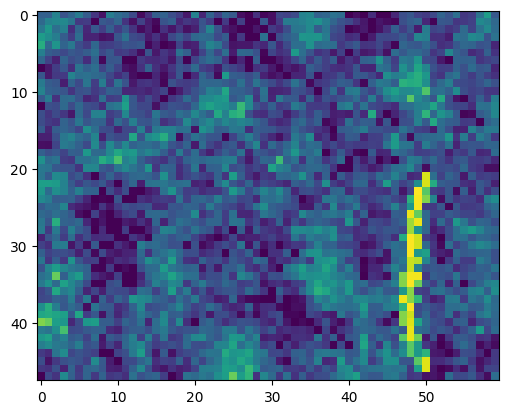

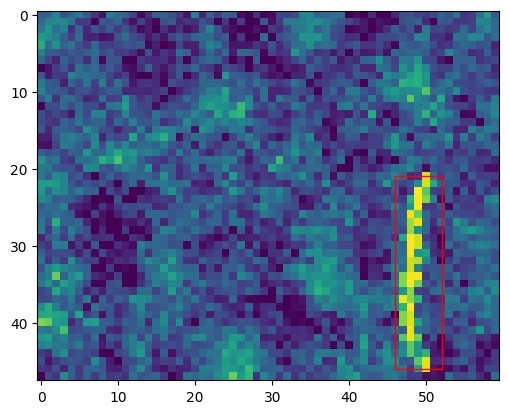

predicted classes  []


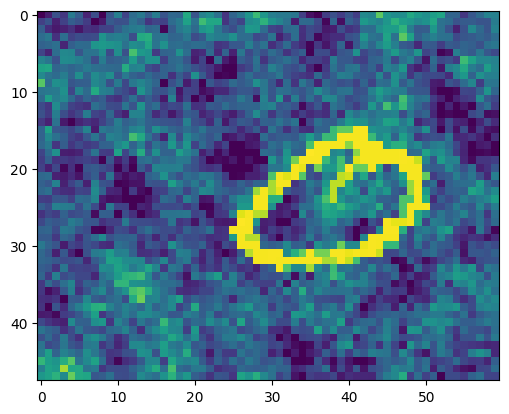

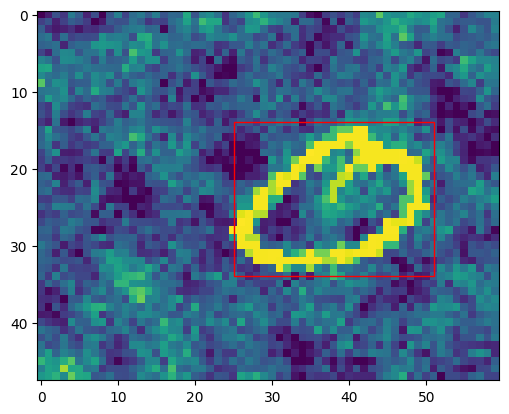

In [93]:
val_loader = torch.utils.data.DataLoader(detection_val_subset, batch_size=64, shuffle=False)
train_loader = torch.utils.data.DataLoader(detection_train_subset, batch_size=64, shuffle=False) 
test_loader = torch.utils.data.DataLoader(detection_test, batch_size=64, shuffle=False) 
BATCH_SIZE = 64
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 0
LOAD_MODELS = ['cnn_configsmalltestearlystop.pth.tar.tar', 'simple_cnn_configsmalltestearlystop.pth.tar','corrected_cnn_config_1smalltestearlystop.pth.tar','alt_cnn_config_3smalltestearlystop.pth.tar','smalltestearlystop.pth.tar']
LOAD_MODEL = False
config_list = ['cnn_config','simple_cnn_config', 'corrected_cnn_config_1', 'alt_cnn_config_3']
threshold=0.5

performance_list = []


def model_selection():
    for i, achitecture in enumerate (config_list):
        #correct_classification = 0
        #total_class = 0
        number_prints = 4
        pic = 0
        model = yolo(cnn__config=cnn_dict[achitecture], s_h=2,s_w=3, num_boxes=1, num_classes=2)
        model.eval()
        optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
        load_checkpoint(torch.load(LOAD_MODELS[i]), model, optimizer)
        for img, label in train_loader:
            output = model(img)
            #output[..., 5:5+2] = torch.softmax(output[..., 5:5+2], dim=-1)
            cell_to_box = cell_to_img(output)
            converted_labels = cell_to_img(label)
            #cc, tc = performance(output, label, correct_classification, total_class)
            #correct_classification += cc
            #total_class += tc
            for idx in range(BATCH_SIZE):
                predicted = []
                non_max = non_max_suppression(cell_to_box[idx],iou_threshold=0.5,threshold=0.5)
                converted_lab = non_max_suppression(converted_labels[idx],iou_threshold=0.5,threshold=0.5)
                if number_prints > pic:
                    for pre in non_max:
                            predicted.append(pre[0])
                    print('predicted classes ', predicted)
                    plot_image(img[idx].permute(1,2,0).to("cpu"), non_max)
                    plot_image(img[idx].permute(1,2,0).to("cpu"), converted_lab)
                    pic += 1
        #performance_list.append(correct_classification/total_class)
    #print(performance_list)
model_selection()


#here we are supposed to predict with the best model on test data. But since we dont have a performance
#meassure there is no reason for this. The code would be identical to the one above but with test_loader
#instead of val_loader.
      